In [7]:
# load functions for data analysis
from fyp_analysis_functions import experimental, visualizeStats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf    
import pandas, os, scipy
import seaborn as sns
import numpy as np
import glob

% pylab inline
pandas.options.mode.chained_assignment = None

Populating the interactive namespace from numpy and matplotlib


In [8]:
day1 = experimental()
day1.day = 1
day1.preprocessData()

In [9]:
day2 = experimental()
day2.day = 2
day2.preprocessData()

In [10]:
cb = []
bc = []
for iSubject in range(0,len(day2.subjectNames)): 
    if str.find(day2.subjectNames[iSubject],'_cb_') != -1: 
        cb.append(iSubject)
    else: 
        bc.append(iSubject)

cb = np.array(cb)
bc = np.array(bc)

In [11]:
iStim = 4
day1.nSeconds = 5
plus, minus = day1.amplitudeDifference('trans',iStim,'onset');

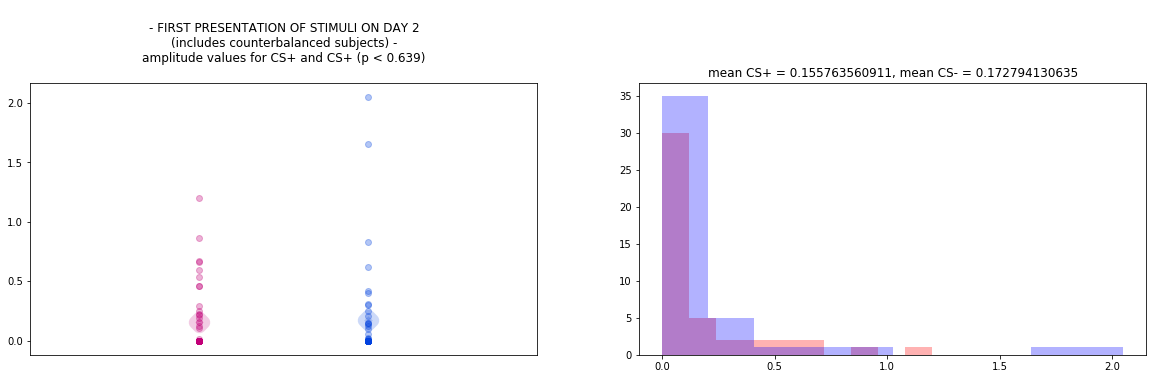

In [12]:
results = scipy.stats.wilcoxon(plus,minus);
visualizeStats(plus,minus,results, 
               heading='FIRST PRESENTATION OF STIMULI ON DAY 2\n(includes counterbalanced subjects)')

In [13]:
CSPs = np.zeros([day1.nSubjects,len(range(3,12))])
CSMs = np.zeros([day1.nSubjects,len(range(3,12))])

day1.nSeconds = 5
conditioning = list(range(3,12))
for iStim in range(0,len(conditioning)):
    CSPs[:,iStim], CSMs[:,iStim] = day1.amplitudeDifference('trans',conditioning[iStim],'offset');
    
conResultsS = np.zeros(day1.nSubjects)
for iSubject in range(0,day1.nSubjects): 
    conResultsS[iSubject] = scipy.stats.wilcoxon(CSPs[iSubject,:],CSMs[iSubject,:])[1];

conditionedSubjects = find(conResultsS<.05)

/Users/ssnl_booth2/anaconda/envs/experimental/lib/python2.7/site-packages/scipy/stats/morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


In [14]:
wrongConditioned = find(mean(CSPs[conditionedSubjects,:]-CSMs[conditionedSubjects,:],1)<0)
#print('%s was conditioned to CS- and said the CS+ was blue...'%day1.subjectNames[wrongConditioned])
#conditionedSubjects = np.delete(conditionedSubjects,wrongConditioned)

In [15]:
sInd = 4
eInd = 13
CSP = np.zeros([day1.nSubjects,len(range(sInd,eInd))])
CSM = np.zeros([day1.nSubjects,len(range(sInd,eInd))])

day1.nSeconds = 4
conditioning = list(range(sInd,eInd))

for iStim in range(0,len(conditioning)):
    CSP[:,iStim], CSM[:,iStim] = day1.amplitudeDifference('trans',conditioning[iStim],'onset');
    
conResults = np.zeros(day1.nSubjects)

for iSubject in range(0,day1.nSubjects): 
    conResults[iSubject] = scipy.stats.wilcoxon(log(1+CSP[iSubject,:]),log(1+CSM[iSubject,:]))[1];


In [16]:
def results_vary_p(p_value): 
    
    conditionedSubjects = find(conResults < p_value)

    cbSubs = 0 
    for iSubject in conditionedSubjects: 
        if iSubject in cb: cbSubs = cbSubs + 1
    bcSubs = 0 
    for iSubject in conditionedSubjects: 
        if iSubject in bc: bcSubs = bcSubs + 1
    print 'with a threshhold of p < ', p_value,'total subjects:', bcSubs + cbSubs, 'counterbalanced subjects:', cbSubs
    iStim = 0

    day2.nSeconds = 4
    plus, minus = day2.amplitudeDifference('trans',iStim,'onset');

    pConditioned = plus[conditionedSubjects]
    mConditioned = minus[conditionedSubjects]

    results = scipy.stats.wilcoxon(pConditioned, mConditioned)
    visualizeStats(pConditioned,mConditioned,results, 
                   heading='in participants with predictions on day 1 (p < %s)'%p_value)

with a threshhold of p <  1 total subjects: 45 counterbalanced subjects: 21


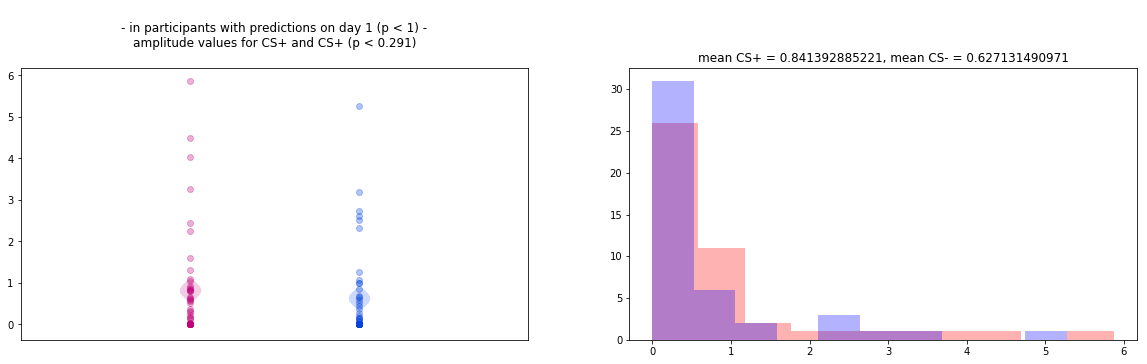

In [17]:
results_vary_p(1)

with a threshhold of p <  0.1 total subjects: 10 counterbalanced subjects: 3


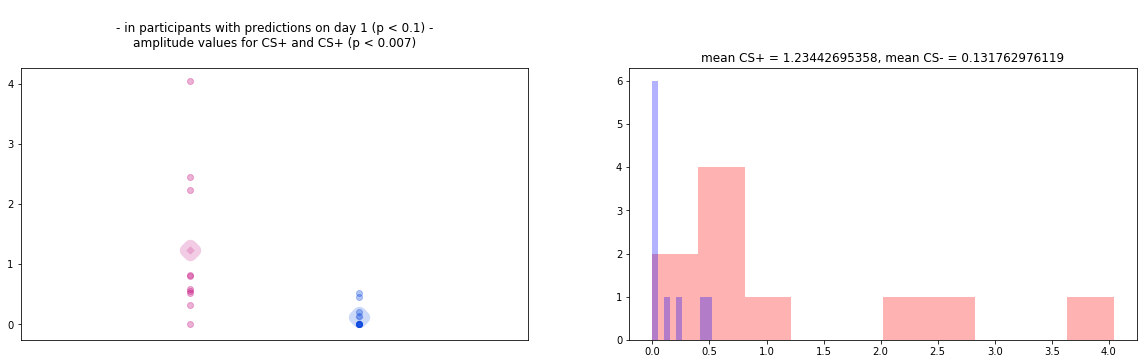

In [18]:
results_vary_p(.1)

with a threshhold of p <  0.05 total subjects: 5 counterbalanced subjects: 2


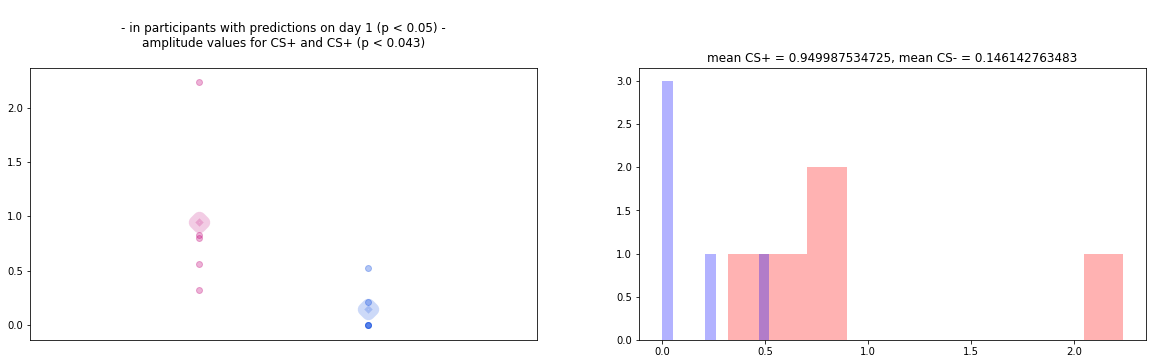

In [19]:
results_vary_p(.05)

Text(0.5,1,u"Relationship between 'anticipation' of shock during conditioning on day 1 with renewal\np=0.084")

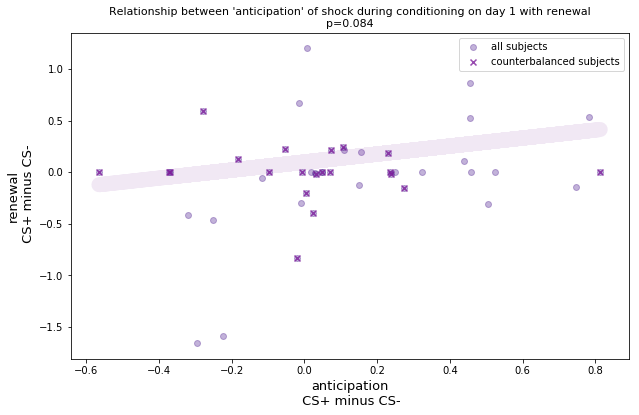

In [20]:
figure(figsize=(10,6))

var1 = mean(CSP - CSM,1)#[conditionedSubjects]
var2 =  plus - minus #plus[conditionedSubjects]-minus[conditionedSubjects]

tmp = smf.OLS(var2,var1).fit()
scatter(var1,var2,color='xkcd:indigo',alpha=.3,label='all subjects')
scatter(var1[cb],var2[cb],color='xkcd:purple',alpha=.8,marker='x',label='counterbalanced subjects')

plot(var1, tmp.predict(var1) + mean(var1), color='xkcd:purple',linewidth=15,alpha=.1)
legend()
xlabel('anticipation\n CS+ minus CS-',fontsize=13)
ylabel('renewal\n CS+ minus CS-',fontsize=13)
title('Relationship between \'anticipation\' of shock during conditioning on day 1 with renewal\np=%.3f'%(tmp.pvalues),fontsize=11)

Text(0.5,1,u'relationship between anticipation of shock on day with renewal on day 2\n p < 0.3146, r^2 = 0.05')

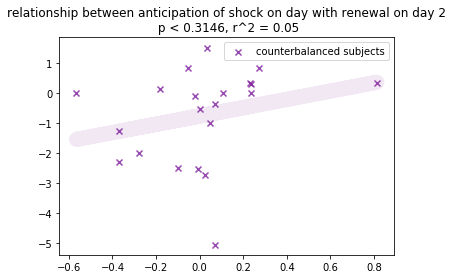

In [26]:
figure(figsize=(6,4))

var1 = mean(CSP - CSM, 1)
var2 =  plus -  minus 

tmpCB = smf.OLS(var2[cb],var1[cb]).fit()

scatter(var1[cb], var2[cb], color='xkcd:purple', alpha=.8, marker='x', label='counterbalanced subjects')

plot(var1[cb], tmpCB.predict(var1[cb]) + mean(var2[cb]), color='xkcd:purple',linewidth=15,alpha=.1)
legend()
title('relationship between anticipation of shock on day with renewal on day 2\n p < %.4f, r^2 = %.2f'%(tmpCB.pvalues,tmpCB.rsquared))

In [105]:
# CREATE A DATA FRAME FOR PHYSIO 

# response to first US
iStim = 4
USplus, USminus = day1.amplitudeDifference('trans',iStim,'offset');
US = USplus - USminus

# last stimulus from extinction
iStim = 21
plus_end, minus_end = day1.amplitudeDifference('trans',iStim,'onset');

# first stimulus on day 2
iStim = 0
plus, minus = day2.amplitudeDifference('trans',iStim,'onset');
# renewal on day 2
renewal = (plus - minus) - (plus_end - minus_end)

# difference across conditioning
difference = mean(CSP - CSM,1) #difference = log(1 + difference)

# take counterbalanced subjects
order = np.zeros(len(plus))
order[cb] = 1 

# create data frame
SCR = pandas.DataFrame({'renewal':renewal,'prediction':difference,'US':US,'order':order})

In [106]:
formula = 'renewal ~ prediction'
model = ols(formula, SCR).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

                sum_sq    df         F    PR(>F)
prediction   27.084255   1.0  5.847611  0.019907
Residual    199.162174  43.0       NaN       NaN


In [107]:
formula = 'renewal ~ US + prediction + C(order)'
model = ols(formula, SCR).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

                sum_sq    df          F    PR(>F)
C(order)     41.401546   1.0  11.065446  0.001863
US           13.198852   1.0   3.527675  0.067477
prediction   15.148221   1.0   4.048685  0.050807
Residual    153.402165  41.0        NaN       NaN


In [76]:
physio = pandas.DataFrame() 
#physio['firstMinusLast'] = ( plusRen - minusRen ) - (plusEnd - minusEnd)
physio['renewal'] = renewal
physio['prediction'] = mean(log(1+CSP)- log(1+CSM),1)
#physio['resonance'] = resonance
physio['US'] = US

#physioTitleNames = ['firstMinusLast','renewal','prediction','US','resonance','meanSurprise']
physioTitleNames = ['renewal','prediction','first US']

renewalPredictionCorr = physio['renewal'].corr(physio['prediction'])
physio.corr()

,renewal,prediction,US
renewal,1.000000,0.295867,0.126745
prediction,0.295867,1.000000,0.129677
US,0.126745,0.129677,1.000000


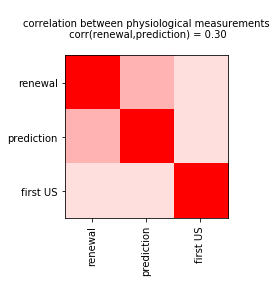

In [77]:
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches([3,3])
ax = imshow(physio.corr())
ax1.set_xticks(np.array(list(range(0,len(physioTitleNames)))))
ax1.set_xticklabels(physioTitleNames,rotation=90,fontsize=10); 
ax1.set_yticks(np.array(list(range(0,len(physioTitleNames)))))
ax1.set_yticklabels(physioTitleNames,fontsize=10); 
ax.set_cmap('bwr') # 'coolwarm' # 'seismic'
ax.set_clim([-1,1])
ax.set_alpha(1)
title('\ncorrelation between physiological measurements\n corr(renewal,prediction) = %.2f\n'%
      (renewalPredictionCorr),fontsize=10); 

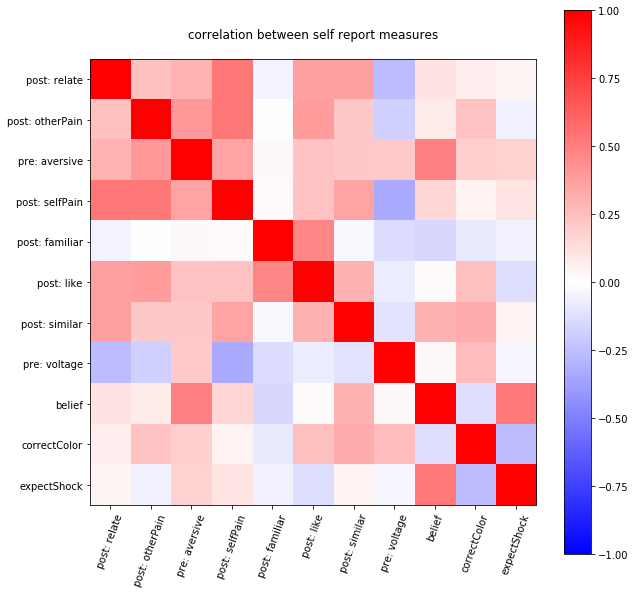

In [80]:
import behavioral_analysis_functions
self_report = behavioral_analysis_functions.generate_data_frame()
behavioral_analysis_functions.correlation_matrix(self_report)

In [27]:
data_path = '/Users/ssnl_booth2/ssl/experiment_2/analysis/data_self_report_study1'

file_names = os.listdir(data_path) 

subject_names = []

for file in file_names:
    if str.find(file, 'part1') != -1:
        subject_names.append(str(file[0:4]))
        

for i_file in file_names: 
    
    if 'part1' in i_file:
    
        day1_info = np.load('%s/%s'%(data_path,i_file)).item()
        questions_day1 = list(day1_info.keys())
    
    elif 'part2' in i_file:
    
        day2_info = np.load('%s/%s'%(data_path,i_file)).item()
        questions_day2 = list(day2_info.keys())
        break

self_report = pandas.DataFrame(index=subject_names, columns=questions_day1+questions_day2)

for i_subject in subject_names: 

    days = glob.glob('%s/%s*'%(data_path, i_subject))
    
    # need to account for awkward irregularities in data collection
    
    for i_day in days:
        tmp_info = np.load(i_day).item()        
        for i_question in range(0,len(tmp_info)):
            if tmp_info.keys()[i_question] == 'post: believe': 
                self_report['belief'][i_subject] = tmp_info[tmp_info.keys()[i_question]]
            else: 
                self_report[tmp_info.keys()[i_question]][i_subject] = tmp_info[tmp_info.keys()[i_question]]       

# clean up some of the errors people made entering the data
self_report['pre: voltage']['s_08'] = 7. 
self_report['pre: voltage']['s_37'] =  5.
self_report['pre: voltage']['s_43'] = 6.0
self_report['pre: voltage']['s_27'] = 3.
self_report['pre: voltage']['s_30'] = 1.1
# 
self_report['post: color']['s_24'] =  'red'
self_report['post: color']['s_43'] =  NaN
# 
self_report['correctColor'] = (self_report['post: color'] == 'red')
self_report['expectShock'] = (self_report['first'] == 'yes')
self_report['belief'] = (self_report['third'] == 'yes')
# 
convert_columns = ['post: relate', 'post: otherPain', 'pre: aversive', 'post: selfPain', 
                   'post: familiar', 'post: like', 'post: similar', 'pre: voltage', 'expectShock', 'belief']

for column in convert_columns: 
    self_report[column] = pandas.to_numeric(self_report[column]); 
    
title_names = self_report.corr().keys()

fig, ax1 = plt.subplots(1,1)
fig.set_size_inches([10,10])
ax = imshow(self_report.corr())
ax1.set_xticks(np.array(list(range(0,len(title_names)))))
ax1.set_xticklabels(title_names,rotation=70); 
ax1.set_yticks(np.array(list(range(0,len(title_names)))))
ax1.set_yticklabels(title_names); 
ax.set_cmap('bwr') # 'coolwarm' # 'seismic'
ax.set_clim([-1,1])
ax.set_alpha(1)
title('correlation between self report measures\n'); 
colorbar()